This is a complete text-to-speech pipeline, using `pretrained tacotron 2` model

- Reference - https://docs.pytorch.org/audio/stable/tutorials/tacotron2_pipeline_tutorial.html

- **tacotron 2**: Tacotron 2 is a neural network architecture developed by Google and implemented by NVIDIA for synthesizing high-quality, natural-sounding speech from text. It works by first converting input text into mel spectrograms—a visual representation of sound frequencies—using a recurrent encoder-decoder model. These mel spectrograms are then fed into a vocoder, such as a modified WaveNet, which transforms them into audible speech waveforms
    - **End-to-End Approach**: Tacotron 2 directly converts text to mel spectrograms, simplifying the process compared to earlier text-to-speech systems that required complex handcrafted acoustic features.

- **mel spectrogram** : A mel spectrogram is a time-frequency visualization of an audio signal that uses the mel scale for the frequency axis instead of the linear Hertz scale, making it more aligned with human auditory perception. It is created by performing a `short-time Fourier transform`, converting the resulting frequencies to the mel scale (a logarithmic scale), and applying a mel filterbank to integrate energy across these perceptually relevant frequency bands. This process provides higher frequency resolution at lower frequencies, which is crucial for tasks like speech recognition and other audio analysis applications

The pipeline goes as follows:
1. Text preprocessing: Input text is encoded into a list of symbols using English character based encoding / phoneme based encoding
    - phoneme: A phoneme is the smallest unit of sound in a language that can distinguish one word from another. For example, the difference between "cat" /kæt/ and "bat" /bæt/ is the initial phoneme, /k/ versus /b/. Phonemes are abstract categories of sound, not the physical sounds themselves, which are called phones

2. Spectrogram generation: With the help of encoded text from step 1 , a spectrogram is generated using the `tacotron 2` model

3. Time-domain conversion: Now the spectrogram is converted into the waveform. A **vocoder** is a category of speech coding that analyzes and synthesizes the human voice signal for audio data compression, multiplexing, voice encryption or voice transformation. The process to generate speech from spectrogram is also called a vocoder. Here , we will use 3 such vocoders namely : WaveRNN , GriffinLim and WaveGlow

visually :

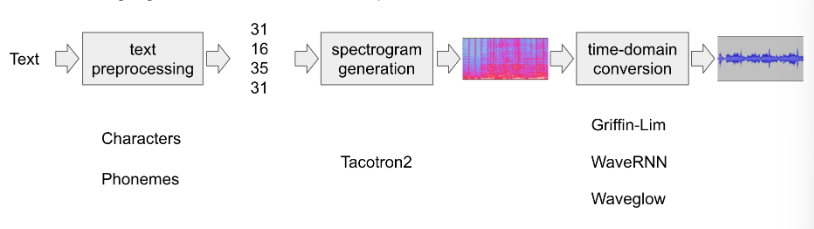

In [2]:
# install necessary dependencies:
!pip install deep_phonemizer

  Preparing metadata (setup.py) ... done
  Created wheel for deep_phonemizer: filename=deep_phonemizer-0.0.19-py3-none-any.whl size=33272 sha256=f358e772f986fad9f371e8d5b516e933443c42ab19c6ea7b779197f883e2b207
  Stored in directory: /root/.cache/pip/wheels/b9/d7/45/f2ae07184a29327b2a7f93b1f734a936c3a34e57225fca603b
Successfully built deep_phonemizer


In [3]:
import torch
import torchaudio

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchaudio.__version__)
print(device)

2.8.0+cu126
2.8.0+cu126
cuda


In [4]:
import IPython
import matplotlib.pyplot as plt

## 1. Text processing:

- The pretrained tacotron2 model expects specific set of symbol tables , this functionality is available in `torchaudio` but we will manually implement this first

- we will map the each character of the input text into the index of the corresponding symbol in the table. Symbols that are not in the table are ignored

### Character based encoding

In [5]:
symbols = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s:i for i , s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
  text = text.lower()
  return [look_up[s] for s in text if s in symbols]

text = "Hello world! Text to speech!"
print(f"Length of text: {len(text)}")
print(f"Character based encoding of text: {text_to_sequence(text)}")
print(f"Length of sequence : {len(text_to_sequence(text))}")

Length of text: 28
Character based encoding of text: [19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15, 2, 11, 31, 16, 35, 31, 11, 31, 26, 11, 30, 27, 16, 16, 14, 19, 2]
Length of sequence : 28


Now that we understand what happens inside , we can use the transform that `torchaudio` provides for this task.

- `torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH` → that’s a prebuilt bundle that contains:

    - Tacotron2 model (text → mel-spectrogram)

    - WaveRNN vocoder (mel → audio waveform)

    - pre-trained weights on the LJSpeech dataset

    - PLUS all the preprocessing utils (like text normalization, char mapping, etc.)

- `get_text_processor()` → that’s the function which gives u the exact text → tensor pipeline they used during training.

    - It tokenizes ur text into chars

    - Normalizes it (like lowercasing, stripping weird symbols)

    - Maps chars to indices

So u don’t have to manually build ur own symbols.py

- **The LJ Speech Dataset**

This is a public domain speech dataset consisting of 13,100 short audio clips of a single speaker reading passages from 7 non-fiction books. A transcription is provided for each clip. Clips vary in length from 1 to 10 seconds and have a total length of approximately 24 hours.

In [6]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()

# text =["Hello world! Text to speech!",
#        "Hey"]

text = "Hello world! Text to speech!"
processed,lengths = processor(text)

print(f"Character based encoding of text: \n {processed}")
print(f"\n Length and datatype of sequence : {lengths}")

Character based encoding of text: 
 tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])

 Length and datatype of sequence : tensor([28], dtype=torch.int32)


- It either takes a text or list of texts as inputs. When a list of texts are provided , the returned lengths variable represents the valid length of each processed tokens in the output batch

- The intermediate representation can be retrieved as follows:


In [7]:
intermediate = [processor.tokens[i] for i in processed[0,:lengths[0]]]
print(f"Intermediate representation : \n{intermediate}")

Intermediate representation : 
['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


### Phoneme based encoding

- Phoneme-based encoding is similar to character-based encoding, but it uses a symbol table based on phonemes and a G2P (Grapheme-to-Phoneme) model.

In [8]:
processor2 = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH.get_text_processor()


text = "Hello world! Text to speech!"
with torch.inference_mode():
  processed , lengths = processor2(text)

print(f"Phoneme based encoding of text: \n {processed}")
print(f"\n Length and datatype of sequence : {lengths}")

100%|██████████| 63.6M/63.6M [00:03<00:00, 18.1MB/s]


Phoneme based encoding of text: 
 tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37,  2]])

 Length and datatype of sequence : tensor([25], dtype=torch.int32)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [9]:
# intermediate response
intermediate = [processor2.tokens[i] for i in processed[0, : lengths[0]]]

print(f"Intermediate representation : \n{intermediate}")

Intermediate representation : 
['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH', '!']


## 2. Spectrogram Generation

- Details of tacotron2 model : https://arxiv.org/abs/1712.05884

- We can instantiate a Tacotron2 model with pretrained weights
    - NOTE : The input to Tacotron2 model needs to be processed by the matching text processor

- `torchaudio.pipelines.Tacotron2TTSBundle` bundles the matching
models and processors together so that it is easy to create the pipeline.

- **Tacotron2TTSBundle** :

- Data class that bundles associated information to use pretrained Tacotron2 and vocoder.

- This class provides interfaces for instantiating the pretrained model along with the information necessary to retrieve pretrained weights and additional data to be used with the model.

- `Tacotron2.infer` method : Tacotron2’s infer method does random sampling, so every time you generate a spectrogram it can come out a bit different

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_characters_1500_epochs_wavernn_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_characters_1500_epochs_wavernn_ljspeech.pth


100%|██████████| 107M/107M [00:02<00:00, 47.0MB/s]


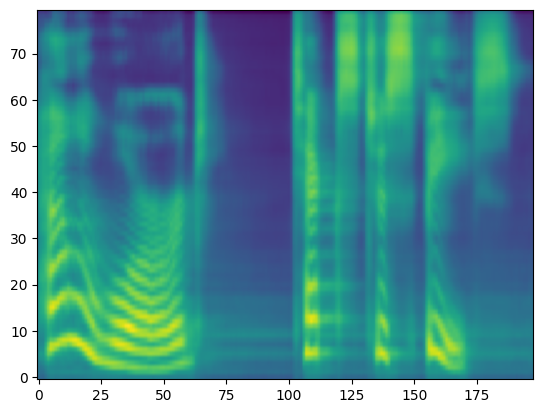

In [22]:
# processor = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH.get_text_processor()
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
tacotron2 = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_tacotron2().to(device)

text = "Hello world! Text to speech!"
with torch.inference_mode():
  processed ,lengths = processor(text)
  processed , lengths = processed.to(device) , lengths.to(device)
  spec , _ , _ = tacotron2.infer(processed , lengths)

_ = plt.imshow(spec[0].cpu().detach() , origin = "lower" , aspect = "auto");

torch.Size([80, 146])
torch.Size([80, 186])
torch.Size([80, 191])


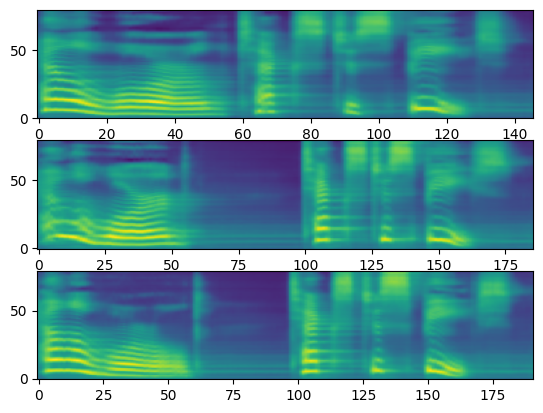

In [23]:
def plot():
  fig , ax = plt.subplots(3,1)
  for i in range(3):
    with torch.inference_mode():
      spec , spec_lengths , _ = tacotron2.infer(processed,lengths)
    print(spec[0].shape)
    ax[i].imshow(spec[0].cpu().detach() , origin="lower",aspect="auto")
plot()

## Waveform Generation:

Now that our spectrogram is generated , the last process is to recover waveform from the spectrogram using a vocoder

`torchaudio` provides vocoders based on `GriffinLim` and `WaveRNN`

- **GRIFFINLIM** refers to the Griffin-Lim Algorithm (GLA), a method in audio processing used to estimate the missing phase information of a signal when only its magnitude spectrum is available

- **WaveRNN** is an autoregressive neural vocoder, a neural network based process for converting low-dimensional acoustic features into an audio waveform by predicting the next sample in a stream of samples. Specialized compute kernels are necessary to make WaveRNN inference fast.

### WaveRNN:


In [32]:
# processor = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH.get_text_processor()
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
tacotron2 = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_tacotron2().to(device)
vocoder = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_vocoder().to(device)
text = "first example of text to speech "
with torch.inference_mode():
  processed ,lengths = processor(text)
  processed , lengths = processed.to(device) , lengths.to(device)
  spec , spec_lengths , _ = tacotron2.infer(processed , lengths)
  waveforms , lengths = vocoder(spec , spec_lengths)



The sampling rate is 22.05kHz.

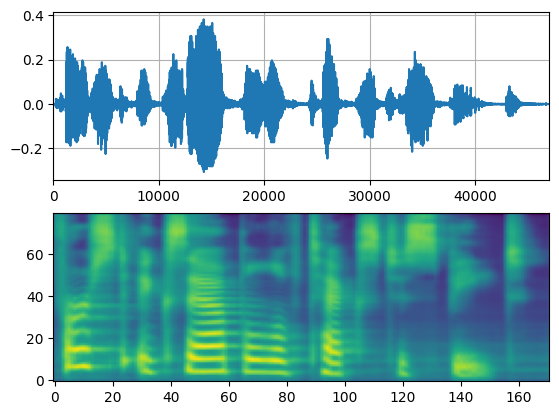

In [33]:
def plot(waveforms , spec , sample_rate):
  waveforms = waveforms.cpu().detach()

  fig , [ax1,ax2] = plt.subplots(2,1)
  ax1.plot(waveforms[0])
  ax1.set_xlim(0, waveforms.size(-1))
  ax1.grid(True)
  ax2.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")
  return IPython.display.Audio(waveforms[0:1] , rate = sample_rate)

plot(waveforms , spec , vocoder.sample_rate)

### Griffin-Lim vocoder

- Using the Griffin-Lim vocoder is same as WaveRNN.

In [34]:
processor = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_text_processor()
tacotron2 = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_tacotron2().to(device)
vocoder = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_CHAR_LJSPEECH.get_vocoder().to(device)
text = "second example of text to speech using griffin lim vocoder "
with torch.inference_mode():
  processed ,lengths = processor(text)
  processed , lengths = processed.to(device) , lengths.to(device)
  spec , spec_lengths , _ = tacotron2.infer(processed , lengths)
  waveforms , lengths = vocoder(spec , spec_lengths)

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_characters_1500_epochs_ljspeech.pth" to /root/.cache/torch/hub/checkpoints/tacotron2_english_characters_1500_epochs_ljspeech.pth


100%|██████████| 107M/107M [00:02<00:00, 50.1MB/s]


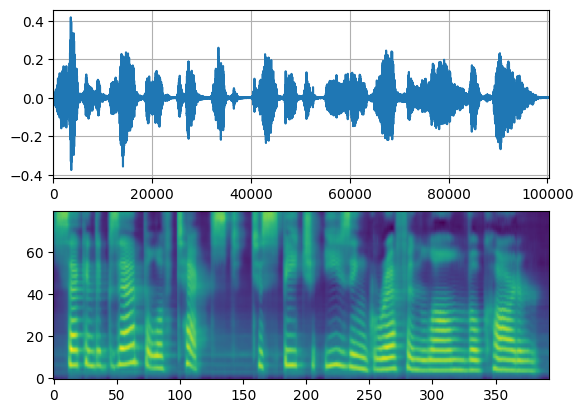

In [36]:
plot(waveforms , spec , vocoder.sample_rate)
# griffin lim vocoder

### Waveglow Vocoder

- Waveglow is a vocoder published by Nvidia. The pretrained weights are published on Torch Hub. One can instantiate the model using torch.hub module.

- reference - https://stackoverflow.com/a/61840832

- https://pytorch.org/hub/nvidia_deeplearningexamples_waveglow/


In [55]:
waveglow = torch.hub.load(
    "NVIDIA/DeepLearningExamples:torchhub",
    "nvidia_waveglow",
    model_math="fp32",
    pretrained = True,
)

# Correct URL for WaveGlow state dictionary
checkpoint = torch.hub.load_state_dict_from_url(
    'https://api.ngc.nvidia.com/v2/models/nvidia/waveglowpyt_fp32/versions/1/files/nvidia_waveglowpyt_fp32_20190306.pth',
    progress = False,
    map_location=device, # Map the checkpoint to the current device
)

# Unwrap the DistributedDataParallel module
# module.layer -> layer
state_dict = {key.replace("module.", ""): value for key, value in checkpoint["state_dict"].items()}

# Apply the state dict to the model
waveglow.load_state_dict(state_dict)
waveglow = waveglow.remove_weightnorm(waveglow)
waveglow.to(device)
waveglow.eval()


text = "Third example using wave glow vocoder"
with torch.inference_mode():
  processed , lengths = processor(text)
  processed , lengths = processed.to(device) , lengths.to(device)
  spec , spec_lengths , _ = tacotron2.infer(processed , lengths)
  waveforms , lengths = vocoder(spec , spec_lengths)


with torch.no_grad():
  waveforms = waveglow.infer(spec)

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/usr/local/lib/python3.12/dist-packages/torch/nn/utils/weight_norm.py:144: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


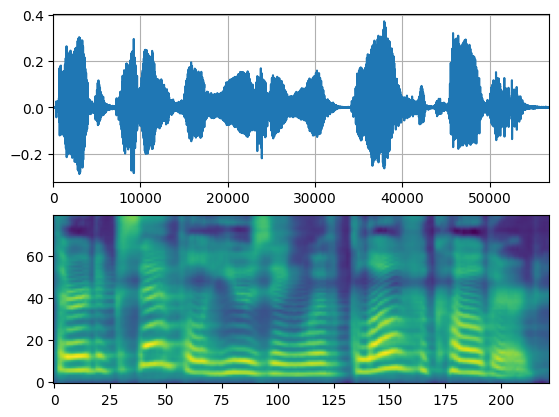

In [56]:
plot(waveforms , spec , 22050)

# Comparing results on same text

/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:337: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.save_with_torchcodec` under the hood. Some parameters like format, encoding, bits_per_sample, buffer_size, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's encoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.encoders.AudioEncoder
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:247: UserWarning: torio.io._streaming_media_encoder.StreamingMediaEncoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3902 for more information. It will be removed from the 2.9 release. 
  s 

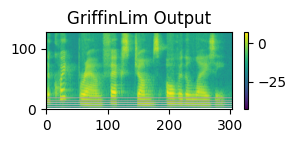

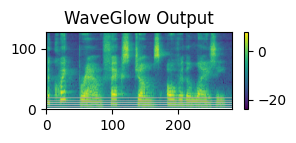

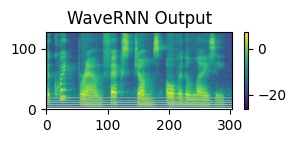

In [59]:
import torch
import torchaudio
import matplotlib.pyplot as plt
import pandas as pd
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
sr = 22050


def generate_audio(vocoder, spec, name):
    """Generate audio + measure time"""
    start = time.time()
    with torch.no_grad():
        if hasattr(vocoder, "infer"):
            audio = vocoder.infer(spec)
        else:
            audio, _ = vocoder(spec, torch.tensor([spec.size(-1)]).to(device))
    elapsed = time.time() - start

    # save
    torchaudio.save(f"{name}.wav", audio.cpu(), sr)
    return audio, elapsed

def plot_mel(waveform, name):
    mel = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform.cpu())
    plt.figure(figsize=(3,1))
    plt.title(name)
    plt.imshow(mel.log2()[0,:,:].numpy(), aspect='auto', origin='lower')
    plt.colorbar()
    plt.show()


bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH
processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)

# input text
text = "The quick brown fox jumps over the lazy dog."
processed, lengths = processor(text)
processed, lengths = processed.to(device), lengths.to(device)

# generate mel-spec
with torch.no_grad():
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)


results = []

# Example vocoders
vocoder_list = {
    "GriffinLim": bundle.get_vocoder().to(device),
    "WaveGlow": waveglow,  # loaded WaveGlow model
    "WaveRNN": bundle.get_vocoder().to(device),
}

for name, vocoder in vocoder_list.items():
    audio, elapsed = generate_audio(vocoder, spec, name)
    plot_mel(audio, f"{name} Output")
    results.append({"Vocoder": name, "Time (s)": elapsed})



In [60]:
# Comparison Table
df = pd.DataFrame(results)
print(df)


      Vocoder   Time (s)
0  GriffinLim  61.093303
1    WaveGlow   0.303783
2     WaveRNN  61.355080
